In [191]:
from WindPy import w
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from WindPy import w
import os
%matplotlib inline

In [181]:
sns.set_style("darkgrid")

In [182]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [228]:
DATA_DIR = "C:/Users/jgtzsx01/Documents/workspace/data/factor-investing"
STOCK_FILE = "%s/stock.xlsx"%(DATA_DIR)
BOND_FILE = "%s/bond.xlsx"%(DATA_DIR)
HK_FILE = "%s/hk.xlsx"%(DATA_DIR)
START_DATE = "2005-01-01"
END_DATE = "2016-12-31"

In [255]:
stock_df = pd.read_excel(STOCK_FILE)

In [256]:
stock_df.set_index('code', inplace=True)

In [257]:
stock_df

,name
code,
CI005001.WI,石油石化
CI005002.WI,煤炭
CI005003.WI,有色金属
CI005004.WI,电力及公用事业
CI005005.WI,钢铁
CI005006.WI,基础化工
CI005007.WI,建筑
CI005008.WI,建材
CI005009.WI,轻工制造


In [258]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [259]:
def get_ranks(asset_df, groups=5):
    length = asset_df.shape[0]
    leng_group = length / groups
    if length % groups > groups / 2:
        leng_group += 1
    ranks = []
    for i in range(1, groups):
        ranks += [i]*leng_group
    ranks += [groups]*(length-len(ranks))
    return ranks

In [260]:
def get_asset_return(asset_df, asset_name, frequency="y"):
    res_df = asset_df.copy()
    for asset in asset_df.index:
        fname = "%s/%s/%s.csv"%(DATA_DIR, asset_name, asset)
        if os.path.exists(fname):
            print fname
            df = pd.read_csv(fname, index_col=0)
            df.index = pd.to_datetime(df.index)
        else:
            data = w.wsd(asset, 'close', START_DATE, END_DATE)
            df = wind2df(data)
            df.to_csv(fname)
            
        if frequency == "y":
            df = df.resample('A').last()
        elif frequency == "m":
            df = df.resample('M').last()
            
        df['return'] = df['close'].pct_change()
        for ind in df.index[1:]:
            if frequency == "y":
                year = ind.year
                res_df.loc[asset, "%d return"%(year)] = df.loc[ind, 'return']
            elif frequency == "m":
                year, month = ind.year, ind.month
                res_df.loc[asset, "%d-%d return"%(year, month)] = df.loc[ind, 'return']
    return res_df

In [398]:
def get_past_return(asset_df, asset_name, days=5, average=False):
    res_df = asset_df.copy()
    for asset in asset_df.index:
        fname = "%s/%s/%s.csv"%(DATA_DIR, asset_name, asset)
        print fname
        df = pd.read_csv(fname, index_col=0)
        df.index = pd.to_datetime(df.index)
        if average:
            df['return'] = df['close'].pct_change()
            df["%d-day return"%(days)] = df['return'].rolling(window=days).mean() # 过去k日平均收益率
        else:
            df['%d-day return'%(days)] = df['close'].pct_change(periods=days) # 过去k日收益率
        df = df.resample('M').last()
        for i, ind in enumerate(df.index[:-1]):
            year, month = df.index[i+1].year, df.index[i+1].month
            res_df.loc[asset, "%d-%d %d-day return"%(year, month, days)] = -df.loc[ind, "%d-day return"%(days)]
#             print asset, "%d-%d %d-day return"%(year, month, days), ind, df.loc[ind, "%d-day return"%(days)]
    return res_df

In [457]:
def get_turnover(asset_df, days=5):
    res_df = asset_df.copy()
    for asset in asset_df.index:
        data = w.wsd(asset, "turn", START_DATE, END_DATE)
        df = wind2df(data)
        df['%d-day turnover'%(days)] = df['turn'].rolling(window=days).mean()
        df = df.resample('M').last()
        for i, ind in enumerate(df.index[:-1]):
            year, month = df.index[i+1].year, df.index[i+1].month
            res_df.loc[asset, "%d-%d %d-day turnover"%(year, month, days)] = -df.loc[ind, "%d-day turnover"%(days)]
    return res_df

In [403]:
def get_group_return(asset_df, factors, weights, ranks):
    assert(len(factors) == len(weights))
    weights = np.array(weights) * 1.0 / sum(weights)
    ranks = np.array(ranks)
    groups = max(ranks)
    group_df = pd.DataFrame(index=range(1, groups+1))
    freqs = set([f.split(' ')[0] for f in stock_df.columns if f.find(' ') != -1])
    for freq in freqs:
        features = ["%s %s"%(freq, f) for f in factors]
        rcol = "%s return"%(freq)
        features.append(rcol)
        df = asset_df[features]
        for f, w in zip(factors, weights):
            df = df.sort_values(by="%s %s"%(freq, f), ascending=False) # 值越小越有价值
            df["%s rank"%(f)] = ranks * w
            
        features = ["%s rank"%(f) for f in factors]
        df["sum rank"] = df[features].sum(axis=1)
        df = df.sort_values(by="sum rank", ascending=True)
        df["rank"] = ranks
        
        group_df[rcol] = df.groupby('rank').mean()[rcol]
    return group_df

# 添加各指数每年的收益率

In [263]:
stock_df = get_asset_return(stock_df, "stock", frequency='m')

C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005001.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005002.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005003.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005004.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005005.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005006.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005007.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005008.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005009.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005010.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005011.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005012.WI.csv
C:/Users/jgtzsx0

# 过去5日收益率

In [422]:
stock_df = get_past_return(stock_df, "stock", days=5, average=True)

C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005001.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005002.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005003.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005004.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005005.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005006.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005007.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005008.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005009.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005010.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005011.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005012.WI.csv
C:/Users/jgtzsx0

# 过去1个月收益率

In [423]:
stock_df = get_past_return(stock_df, "stock", days=20, average=True)

C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005001.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005002.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005003.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005004.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005005.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005006.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005007.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005008.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005009.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005010.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005011.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005012.WI.csv
C:/Users/jgtzsx0

# 过去2个月收益率

In [424]:
stock_df = get_past_return(stock_df, "stock", days=120, average=True)

C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005001.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005002.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005003.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005004.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005005.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005006.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005007.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005008.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005009.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005010.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005011.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005012.WI.csv
C:/Users/jgtzsx0

# 过去3个月收益率

In [425]:
stock_df = get_past_return(stock_df, "stock", days=243, average=True)

C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005001.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005002.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005003.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005004.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005005.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005006.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005007.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005008.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005009.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005010.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005011.WI.csv
C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/stock/CI005012.WI.csv
C:/Users/jgtzsx0

# 过去5日换手率

In [497]:
stock_df.sort_index()

,name,2005-2 return,2005-3 return,2005-4 return,2005-5 return,2005-6 return,2005-7 return,2005-8 return,2005-9 return,2005-10 return,...,2016-3 5-day turnover,2016-4 5-day turnover,2016-5 5-day turnover,2016-6 5-day turnover,2016-7 5-day turnover,2016-8 5-day turnover,2016-9 5-day turnover,2016-10 5-day turnover,2016-11 5-day turnover,2016-12 5-day turnover
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.119650,-0.082533,-0.019008,-0.107732,0.021315,0.031912,0.117113,-0.008703,-0.063099,...,-0.28004,-0.25982,-0.19556,-0.14112,-0.16662,-0.18414,-0.14248,-0.13056,-0.20724,-0.29562
CI005002.WI,煤炭,0.130761,-0.107633,0.015134,-0.132142,-0.075732,-0.041931,0.015111,0.043744,-0.116103,...,-1.67916,-0.76290,-1.03776,-0.59390,-0.75748,-0.76116,-0.60648,-0.73580,-1.60174,-1.27216
CI005003.WI,有色金属,0.141099,-0.111822,-0.017263,-0.099106,0.005148,-0.042460,0.106784,0.064712,-0.075181,...,-2.21348,-1.81334,-1.42818,-1.41856,-2.14028,-1.99962,-1.05630,-0.78798,-1.45878,-2.53986
CI005004.WI,电力及公用事业,0.078857,-0.088172,-0.009859,-0.063934,0.051293,-0.002562,0.025017,-0.009448,-0.071457,...,-1.29420,-0.98326,-0.60244,-0.56866,-0.86652,-0.91558,-0.90428,-0.71284,-1.00926,-1.19822
CI005005.WI,钢铁,0.074207,-0.097204,-0.101365,-0.048186,0.030876,0.013474,-0.014439,-0.031527,-0.052417,...,-1.58428,-0.85682,-0.68586,-0.66152,-0.66030,-0.58646,-0.65252,-0.50074,-0.88556,-1.46074
CI005006.WI,基础化工,0.107023,-0.068936,-0.004672,-0.110753,0.006115,-0.053495,0.108957,0.022842,-0.045237,...,-2.51346,-2.58146,-1.87030,-1.78350,-2.34778,-2.09932,-1.75242,-1.67078,-1.92636,-1.90594
CI005007.WI,建筑,0.114503,-0.146377,-0.062489,-0.037497,0.007579,-0.104863,0.151029,0.017761,-0.056612,...,-0.99984,-0.84658,-0.56248,-0.54116,-0.78480,-0.91460,-1.08426,-0.78882,-1.34338,-2.29938
CI005008.WI,建材,0.099195,-0.138937,-0.106926,-0.032051,-0.007706,-0.062991,0.148838,0.039524,-0.024497,...,-2.59570,-2.39560,-1.71562,-1.56258,-1.98852,-2.19978,-1.74628,-1.43500,-1.97742,-2.29888
CI005009.WI,轻工制造,0.067891,-0.117231,-0.039307,-0.036816,0.000464,-0.028363,0.040143,0.002194,-0.090822,...,-2.74598,-2.70892,-1.98460,-1.70744,-2.44418,-2.17840,-1.50820,-1.11612,-1.53418,-2.21738


In [458]:
stock_df = get_turnover(stock_df, days=5)

In [459]:
ranks = get_ranks(stock_df, 5)

In [489]:
# factors = ["5-day return", "20-day return", "120-day return", "243-day return"]
# weights = [1, 1, 0, 0]
factors = ["5-day turnover", "5-day return", "20-day return", "120-day return"]
weights = [1, 1, 1, 1]

In [490]:
group_df = get_group_return(stock_df, factors, weights, ranks)

In [491]:
group_df

,2007-8 return,2007-9 return,2007-4 return,2007-5 return,2007-6 return,2007-7 return,2007-1 return,2007-2 return,2007-3 return,2015-11 return,...,2009-11 return,2009-12 return,2008-4 return,2013-7 return,2013-6 return,2008-9 return,2008-8 return,2013-3 return,2013-2 return,2013-1 return
1,0.116712,0.012770,0.253419,0.100491,-0.063453,0.186966,0.293348,0.088395,0.085667,0.004756,...,0.111784,0.044593,-0.009652,0.020566,-0.169057,-0.031878,-0.205078,-0.052484,0.013230,0.054341
2,0.150381,0.037430,0.293025,0.122491,-0.097773,0.151742,0.238398,0.103095,0.107912,0.054943,...,0.094627,0.015756,0.000693,0.024273,-0.164121,-0.047536,-0.216052,-0.020609,0.016667,0.045236
3,0.110587,0.040786,0.301352,0.069473,-0.071852,0.190878,0.221739,0.120204,0.159723,0.056058,...,0.122649,0.037841,0.098178,0.030138,-0.158805,-0.056561,-0.209564,-0.047969,0.016836,0.043200
4,0.151737,0.053989,0.303097,0.068383,-0.136443,0.182593,0.164509,0.120806,0.125305,0.104469,...,0.125227,0.022630,0.002910,0.030709,-0.161008,-0.050553,-0.193279,-0.023749,0.045667,0.097774
5,0.142107,0.120272,0.395495,0.088711,-0.092715,0.223573,0.146406,0.190763,0.122157,0.105683,...,0.117741,0.026820,-0.038235,0.152294,-0.093642,-0.051580,-0.206773,-0.062961,0.021967,0.070487


In [492]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

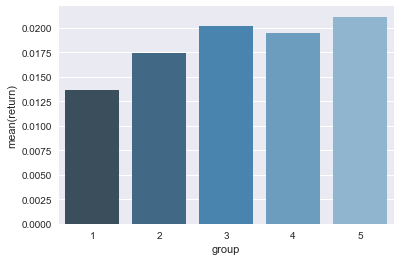

In [493]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [494]:
start_year = 2015
year_feature = []
for year in range(start_year, 2017):
    year_feature += ["%d-%d return"%(year, month) for month in range(1, 13)]

In [495]:
res = group_df[year_feature].mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

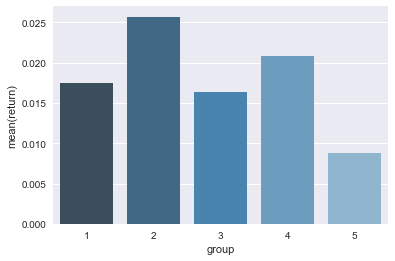

In [496]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [445]:
group_df.to_excel("%s/momentum.xlsx"%(DATA_DIR))

# 港股

In [156]:
hk_df = pd.read_excel(HK_FILE)

In [157]:
hk_df.set_index('code', inplace=True)

In [158]:
hk_df = get_asset_return(hk_df, frequency='m')

In [159]:
for stock in hk_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df['return'] = df.pct_change()
    df['avg return'] = df['return'].rolling(window=30).mean()
    df = df.resample('M').last()
    for i, ind in enumerate(df.index[:-1]):
        year, month = df.index[i+1].year, df.index[i+1].month
        hk_df.loc[stock, "%d-%d momentum"%(year, month)] = -df.loc[ind, "avg return"]

In [160]:
ranks = get_ranks(hk_df)

In [161]:
factors = ["momentum"]
weights = [1]

In [162]:
group_df = get_group_return(hk_df, factors, weights, ranks)

In [163]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

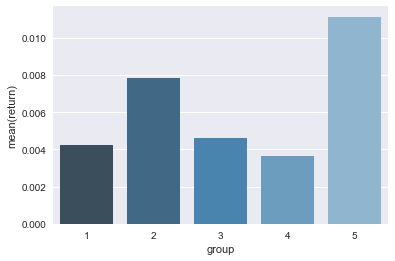

In [164]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [165]:
group_df.to_excel("%s/hk_momentum.xlsx"%(DATA_DIR))